In [1]:
"""
Created on Thu Jul  5 16:20:37 2018

@author: dsananez
"""
import pandas as pd
import source as sc

ofertas = pd.read_csv('listado_campanas.txt')
print(ofertas)


d = {'fact': [220,250.3,230,500,420,125,600,623,121,597,875,210],
    'ani': ['1','2','3','4','5','6','7','8','9','10','11','12'],
    'churn_calibrated': [0.01,0.03,0.02,0.06,0.08,0.09,0.12,0.05,0.01,0.02,0.01,0.02]}
data3 = pd.DataFrame(data=d)

        id_oferta tipo_oferta  duracion  fact_esp      tipo_fact  \
0  cater_30_gama1       cater        12      0.00          delta   
1      desc_50_12   descuento        12     -0.50  aumento_porct   
2   desc_15_indef   descuento        -1     -0.15  aumento_porct   
3      upsell_mod     up_sell        -1      0.10  aumento_porct   
4       cross_mod  cross_sell        -1      0.10  aumento_porct   
5       bono_2g_6        bono         6      0.00  aumento_porct   
6          ftth_1  cross_sell        -1   1000.00          delta   
7         fact_sp    refuerzo        -1      0.00          delta   

   churn_esp_n1     tipo_churn  aceptacion_in  aceptacion_out  subsidio  \
0         0.005           fijo          0.035           0.035       816   
1        -0.990  aumento_porct          0.990           0.990         0   
2        -0.990  aumento_porct          0.790           0.830         0   
3        -0.300  aumento_porct          0.100           0.150         0   
4        -0.

AxesSubplot(0.125,0.125;0.775x0.755)
  ani       0       1       2       3       4       5       6       7       8  \
0   1  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0   

    ...        14      15      16      17      18      19      20      21  \
0   ...    1220.0  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0  1220.0   

       22      23  
0  1220.0  1220.0  

[1 rows x 25 columns]


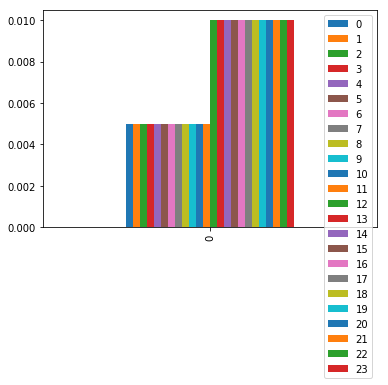

In [29]:
%matplotlib inline
t = 24
print(sc.churn_t(data3, ofertas, t)['ftth_1'][:1].plot(kind='bar'))
print(sc.fact_t(data3, ofertas, t)['ftth_1'][:1])


In [7]:
import pandas as pd
import numpy as np

def costo_plataforma(df, t_util = 8, efic_rep = 0.75, dias_lab = 6, q_sem = 4):
    """
    Calcula costes de plataforma IN/OUT, donde
        df: data frame con columna tipo_oferta
        t_util: horas utiles diarias por rep
        efic_rep: % de eficiencia promedio por rep
        dias_lab: cantidad de dias disponibles para llamar (por semana)
        q_sem: cantidad de semanas al mes
    :return:
    """
    ofertas = pd.read_csv('modelo_plataforma_cc.txt', sep=",")
    ofertas['cost_plat_in'] = 0
    ofertas['cost_plat_out'] = ofertas['cost_hora_pos']*ofertas['dur_llam_out']/ofertas['efic_rep']
    
    result = pd.merge(df, ofertas, on = 'tipo_oferta', how = 'left')
    
    return result[['cost_plat_in','cost_plat_out']]

def costo_sac(df):
    """
    Calcula costes SAC totales, donde
        df: data frame con columnas:
            - subsidio
            - logistica
            - comisiones
    :return:
    """
    costo_sac = {'cost_sac': df['subsidio'] + df['logistica'] + df['comisiones']}
    costo_sac_df = pd.DataFrame(data=costo_sac)
    return costo_sac_df

def costo_campana(df):
    """
    Calcula costes de campana totales IN/OUT, donde
        df: data frame con columnas:
            - cost_plat_in
            - cost_plat_out
            - cost_sac
        :return:
     """
    cost_campana = {'cost_campana_in': df['cost_plat_in'], 
                    'cost_campana_out': df['cost_plat_out'],
                    'cost_sac': df['cost_sac']}
    
    cost_campana_df = pd.DataFrame(data=cost_campana)
    return cost_campana_df

def costo_total(df, t_util = 8, efic_rep = 0.75, dias_lab = 6, q_sem = 4):
    """
    Corre las 3 funciones anteriores, donde
        df: data frame con columna tipo_oferta
        t_util: horas utiles diarias por rep
        efic_rep: % de eficiencia promedio por rep
        dias_lab: cantidad de dias disponibles para llamar (por semana)
        q_sem: cantidad de semanas al mes
    :return:
    """
    
    cost_plat = costo_plataforma(df, t_util, efic_rep, dias_lab, q_sem)
    cost_sac = costo_sac(df)
    cost_campana = costo_campana(pd.concat([cost_plat, cost_sac], axis=1))
    return cost_campana

def fact_24(df):
    """
    Calcula facturacion estimada proximos 24 meses, donde
        df: data frame con columnas: 
            - msisdn_id: ani del cliente
            - fact: facturacion plan + excedentes
        listado_campanas.txt: archivo de texto con informacion de las campañas
    :return:
    """
    
    fact_oferta = {}
    ofertas = pd.read_csv('listado_campanas.txt', sep=",")
    
    for i in range(0,len(ofertas)):
        fact_esp = ofertas['fact_esp'][i]
        fact = np.array([], dtype=np.float).reshape(0,24)
        
        if ofertas['tipo_oferta'][i] == 'cater':
            
            if ofertas['tipo_fact'][i] == 'delta':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k] + fact_esp, 12)) + list(np.repeat(df['fact'][k], 12)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k]*(1+fact_esp), 12)) + list(np.repeat(df['fact'][k], 12)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'fijo':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(fact_esp, 12)) + list(np.repeat(df['fact'][k], 12)) 
                    fact = np.vstack([fact, fact_24])
        
        elif ofertas['tipo_oferta'][i] == 'bono':
            
            duracion = int(ofertas['id_oferta'][i].split('_')[2])
            
            if ofertas['tipo_fact'][i] == 'delta':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k] + fact_esp, duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k]*(1+fact_esp), duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'fijo':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(fact_esp, duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])
                    
        elif ofertas['tipo_oferta'][i] == 'cross_sell':
    
            if ofertas['tipo_fact'][i] == 'delta':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k] + fact_esp, 24)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k]*(1+fact_esp), 24)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'fijo':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(fact_esp, 24))
                    fact = np.vstack([fact, fact_24])
        
        elif ofertas['tipo_oferta'][i] == 'up_sell':
    
            if ofertas['tipo_fact'][i] == 'delta':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k] + fact_esp, 24)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k]*(1+fact_esp), 24)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'fijo':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(fact_esp, 24))
                    fact = np.vstack([fact, fact_24])
                    
        elif ofertas['tipo_oferta'][i] == 'descuento':
            
            if ofertas['id_oferta'][i].split('_')[2] == 'indef':
                duracion = 24
            else:
                duracion = int(ofertas['id_oferta'][i].split('_')[2])
            
            if ofertas['tipo_fact'][i] == 'delta':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k] + fact_esp, duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(df['fact'][k]*(1+fact_esp), duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])
            elif ofertas['tipo_fact'][i] == 'fijo':
                for k in range(0,len(df)):
                    fact_24 = list(np.repeat(fact_esp, duracion)) + list(np.repeat(df['fact'][k], 24-duracion)) 
                    fact = np.vstack([fact, fact_24])                    
        
                    
        fact_oferta[ofertas['id_oferta'][i]] = pd.concat([df['msisdn_id'], pd.DataFrame(data=fact)], axis=1)
        
    return fact_oferta

def churn_post_oferta(churn_orig, churn_nvo, dur_oferta, progresivo = True):
    """
    Calcula churn estimado al vencimiento de una oferta, donde
        churn_orig: churn antes de aceptar la oferta 
        churn_nvo: churn despues de aceptar la oferta 
        dur_oferta: duracion de la oferta (meses)
        dur_blindaje: duracion del blindaje
    :return:
    """
    churn_of = list(np.repeat(churn_nvo, dur_oferta))
   
    churn_blin = list()
    
    if progresivo:
        churn_n = churn_nvo*1.1
        while churn_n < churn_orig and len(churn_blin) < 24 - dur_oferta:
            churn_blin.append(churn_n)
            churn_n = churn_n*1.1
    
    churn_po = list(np.repeat(churn_orig, 24 - dur_oferta - len(churn_blin)))
    
    return churn_of + churn_blin + churn_po

def churn_24(df):
    """
    Calcula churn estimado proximos 24 meses, donde
        df: data frame con columnas: 
            - msisdn_id: ani del cliente
            - churn_calibrated: churn mensual calibrado (probabilidad real)
        listado_campanas.txt: archivo de texto con informacion de las campañas
    :return:
    """
    
    churn_oferta = {}
    ofertas = pd.read_csv('listado_campanas.txt', sep=",")
    
    for i in range(0,len(ofertas)):
        churn_esp = ofertas['churn_esp_n1'][i]
        churn = np.array([], dtype=np.float).reshape(0,24)
        
        if ofertas['tipo_oferta'][i] == 'cater':
            
            if ofertas['tipo_churn'][i] == 'delta':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k] + churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k]*(1+churn_esp)
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'fijo':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12)
                    churn = np.vstack([churn, churn_24])
        
        elif ofertas['tipo_oferta'][i] == 'bono':
            
            duracion = int(ofertas['id_oferta'][i].split('_')[2])
            
            if ofertas['tipo_churn'][i] == 'delta':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k] + churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k]*(1+churn_esp)
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'fijo':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])
                    
        elif ofertas['tipo_oferta'][i] == 'cross_sell':
    
            if ofertas['tipo_churn'][i] == 'delta':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k] + churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k]*(1+churn_esp)
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'fijo':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
        
        elif ofertas['tipo_oferta'][i] == 'up_sell':
    
            if ofertas['tipo_churn'][i] == 'delta':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k] + churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k]*(1+churn_esp)
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'fijo':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, 12, progresivo = False)
                    churn = np.vstack([churn, churn_24])
                    
        elif ofertas['tipo_oferta'][i] == 'descuento':
            
            if ofertas['id_oferta'][i].split('_')[2] == 'indef':
                duracion = 24
            else:
                duracion = int(ofertas['id_oferta'][i].split('_')[2])
                
            if ofertas['tipo_churn'][i] == 'delta':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k] + churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'aumento_porct':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = df['churn_calibrated'][k]*(1+churn_esp)
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])
            elif ofertas['tipo_churn'][i] == 'fijo':
                for k in range(0,len(df)):
                    churn_orig = df['churn_calibrated'][k]
                    churn_nvo = churn_esp
                    churn_24 = churn_post_oferta(churn_orig, churn_nvo, duracion)
                    churn = np.vstack([churn, churn_24])                    
                    
        churn_oferta[ofertas['id_oferta'][i]] = pd.concat([df['msisdn_id'], pd.DataFrame(data=churn)], axis=1)
        
    return churn_oferta


churn_24(data3)

{'bono_2g_6':    msisdn_id      0      1      2      3      4      5       6        7  \
 0          1  0.005  0.005  0.005  0.005  0.005  0.005  0.0055  0.00605   
 1          2  0.015  0.015  0.015  0.015  0.015  0.015  0.0165  0.01815   
 2          3  0.010  0.010  0.010  0.010  0.010  0.010  0.0110  0.01210   
 3          4  0.030  0.030  0.030  0.030  0.030  0.030  0.0330  0.03630   
 4          5  0.040  0.040  0.040  0.040  0.040  0.040  0.0440  0.04840   
 5          6  0.045  0.045  0.045  0.045  0.045  0.045  0.0495  0.05445   
 6          7  0.060  0.060  0.060  0.060  0.060  0.060  0.0660  0.07260   
 7          8  0.025  0.025  0.025  0.025  0.025  0.025  0.0275  0.03025   
 8          9  0.005  0.005  0.005  0.005  0.005  0.005  0.0055  0.00605   
 9         10  0.010  0.010  0.010  0.010  0.010  0.010  0.0110  0.01210   
 10        11  0.005  0.005  0.005  0.005  0.005  0.005  0.0055  0.00605   
 11        12  0.010  0.010  0.010  0.010  0.010  0.010  0.0110  0.01210   

In [2]:
import pandas as pd
import numpy as np
import random 
import source as fp

class ofertas():
    def __init__(self, name, acp, tipo_oferta, df, costos, tasa):
        self.oferta = name
        self.tipo = tipo_oferta
        self.aceptacion = acp
        self.cliente = df
        self.costos = costos
        self.tasa_interes = tasa

class cliente():
    def __init__(self,cuit,razon_social,df):
        self.cliente = df
        self.cuit = cuit
        self.rs = razon_social

def calculo_cltv(dataOferta, dataSinOferta):
    
##Calculo del customer lifetime value

    t1 = 1/(dataSinOferta['prob_churn']).mean()
    t2 = 1/min(dataSinOferta['prob_churn'].mean(), dataOferta.cliente['prob_churn'].mean())


    ltv_con = (dataOferta.aceptacion * ((dataOferta.cliente['facturacion']-dataOferta.costos).mean())*t2)+((1-dataOferta.aceptacion)* ((dataSinOferta['facturacion']-dataOferta.costos).mean())*t1)
        
    ltv_sin = (dataSinOferta['facturacion'].mean())*t1

    return ltv_con - ltv_sin


def calculo_van_diff(dataOferta,dataSinOferta):

    ##Calculo del valor actual neto con oferta    
    van_con = 0    
    for i in range(0,round(len(dataOferta.cliente['facturacion']))):
        van_con = van_con + (dataOferta.cliente['facturacion'].values[i]-dataOferta.costos[i])*((1-dataOferta.cliente['prob_churn'].values[i]))*(pow((1+dataOferta.tasa_interes.mean()),i))

    ##valor actual neto sin oferta
    van_sin = 0 
    for i in range(0,round(len(dataOferta.cliente['facturacion']))):
        van_sin = van_sin + (dataSinOferta['facturacion'].values[i])*((1-dataSinOferta['prob_churn'].values[i]))*(pow((1+dataOferta.tasa_interes.mean()),i))    

    #valor actual neto con oferta teniendo en cuenta la aceptacion de la oferta
    van_oferta = (dataOferta.aceptacion)*van_con + (1-dataOferta.aceptacion)*(van_sin-dataOferta.costos[0])

    #Score por oferta en un determinado cliente
   

    return van_oferta - van_sin	


def mejor_oferta(fact_oferta,churn_oferta,k,costos_of,aceptacion,tasa_interes,cliente,func_obj):

    dataOferta = {}
    ##Ajusto variables de entrada para el calculo de los valores actuales cuando se hace una oferta
    for i in range(0,len(fact_oferta)):


        nombre = list(fact_oferta.keys())[i]
        tipo = list(fact_oferta.keys())[i].split('_')[0]
        acep = aceptacion[i]
        df = pd.DataFrame(columns=['facturacion','prob_churn'])
        df['facturacion'] = pd.Series(list(fact_oferta[nombre].loc[k,:])[1:])
        df['prob_churn'] = pd.Series(list(churn_oferta[nombre].loc[k,:])[1:])
        tasa_interes = pd.Series(tasa_interes)
        costos = np.zeros(24)
        costos[0] = costos_of[i]
    
        dataOferta[i] = ofertas(nombre,acep,tipo,df,costos,tasa_interes)

    dataSinOferta = pd.DataFrame()

    dataSinOferta['facturacion'] = cliente.cliente['facturacion']
    dataSinOferta['prob_churn'] = cliente.cliente['prob_churn']
    


    ##Calculo la diferencia entre valores actuales netos con y sin oferta
    scores = pd.Series()

    for i in range(0,len(dataOferta)):
        if(func_obj == 'van'):
            scores[dataOferta[i].oferta] = calculo_van_diff(dataOferta[i],dataSinOferta)
        elif(func_obj == 'ltv'):
            scores[dataOferta[i].oferta] = calculo_cltv(dataOferta[i],dataSinOferta)

    ##Ordeno de mayor a menor y expongo las dos principales ofertas y sus scores.
    ordenados = scores.sort_values(ascending=False)

    print('Oferta principal: '+ordenados.index.values[0]+' con un score de '+str((ordenados.values[0])))
    print('Oferta secundaria: '+ordenados.index.values[1]+' con un score de '+str((ordenados.values[1])))
    print('-------------')

    #devuelvo los scores ordenados para cada oferta
    return ordenados


if __name__ == "__main__":

    #BANCO DE PRUEBAS
    
    ##FACTURACION CLIENTES NORMAL

    d = {'msisdn_id': ['1','2','3','4','5','6','7','8','9','10','11','12'],
    'fact': [220,250.3,230,500,420,125,600,623,121,597,875,210],
    'churn_calibrated': [0.1,0.02,0.05,0.06,0.02,0.02,0.04,0.09,0.02,0.01,0.03,0.07]}
    
    data = pd.DataFrame(data=d)
    
    clientes = {}
    df = pd.DataFrame()
    
    ##Datos del cliente
    for i in range(0,len(data['msisdn_id'])):
        cuit = data['msisdn_id'].values[i]
        rs = 'empresa_'+data['msisdn_id'].values[i]
        df['facturacion'] = pd.Series(data['fact'].values[i]*np.ones(24))
        df['prob_churn'] = pd.Series(data['churn_calibrated'].values[i]*np.ones(24))
    
        clientes[i] = cliente(cuit,rs,df)

    #FACTURACION CUANDO SE APLICA LA OFERTA
    fact_oferta = fp.fact_24(data)

    ##REEMPLAZAR POR EL CHURN CON OFERTA
    churn_oferta = fp.churn_24(data)

    for i in range(0,len(churn_oferta)):
        nombre = list(churn_oferta.keys())[i]
        churn_oferta[nombre][churn_oferta[nombre].columns[1:]] = (churn_oferta[nombre][churn_oferta[nombre].columns[1:]]/1000)*(random.random())
        
    of = pd.read_csv('listado_campanas.txt', sep=",")
    
    ##Aceptacion Ofertas
    aceptacion_in = list(of['aceptacion_in'])
    aceptacion_out = list(of['aceptacion_out'])
    
    ##Costos
    
    costos_in = list(fp.costo_total(of)['cost_campana_in'])
    costos_out = list(fp.costo_total(of)['cost_campana_out'])
    
    ##Tasa Interes
    tasa_interes = list(0.02*np.ones(24))

    ##Funcion objetivo ('van' o 'ltv')
    func_obj = 'van'

    NBA_in = pd.DataFrame()
    NBA_out = pd.DataFrame()

    for i in range(0,len(clientes)):
        print('NBA para la '+clientes[i].rs+' canal IN')
        NBA_in[clientes[i].rs] = mejor_oferta(fact_oferta,churn_oferta,i,costos_in,aceptacion_in,tasa_interes,clientes[i],func_obj)
        print('NBA para la '+clientes[i].rs+' canal OUT')
        NBA_out[clientes[i].rs] = mejor_oferta(fact_oferta,churn_oferta,i,costos_out,aceptacion_out,tasa_interes,clientes[i],func_obj)

    print(NBA_in)
    print(NBA_out)

NBA para la empresa_1 canal IN
Oferta principal: bono_2g_6 con un score de 331.3039276762611
Oferta secundaria: cross_mod con un score de 139.36797437517816
-------------
NBA para la empresa_1 canal OUT
Oferta principal: bono_2g_6 con un score de 561.8667133577674
Oferta secundaria: cross_mod con un score de 207.16196269386273
-------------
NBA para la empresa_2 canal IN
Oferta principal: bono_2g_6 con un score de 786.5170457509212
Oferta secundaria: desc_15_indef con un score de 315.90619242296634
-------------
NBA para la empresa_2 canal OUT
Oferta principal: bono_2g_6 con un score de 1335.7289850381903
Oferta secundaria: desc_15_indef con un score de 461.3490836697147
-------------
NBA para la empresa_3 canal IN
Oferta principal: bono_2g_6 con un score de 481.5553939395377
Oferta secundaria: cross_mod con un score de 172.8330365121028
-------------
NBA para la empresa_3 canal OUT
Oferta principal: bono_2g_6 con un score de 817.2941878512756
Oferta secundaria: cross_mod con un score 

In [4]:
sc.costo_total(data2)

TypeError: costo_total() missing 1 required positional argument: 'plataforma'